Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import copy
import pickle
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed

## Simulating the training Data T

Definition of the function !

In [3]:
def simulate_T(ro,SNR,used_features,n=60,p=30,intercept=0):
    '''
    
    used_features: int, the number of features used (5 or 25 in our case)
    ro: float, the correlation between the features
    SNR: float, the signal to noise ratio
    n: int, the number of samples
    p: int, the number of features
    SEED: int, the random seed

    returns:    X: np.array, the features matrix n x p 
                y: np.array, the response variable n x 1

    '''
    # Generate the covariance matrix
    COV = np.zeros((p,p))
    for i in range(p):
        for j in range(p):
            COV[i,j] = ro**abs(i-j)

    # Generate X
    X = np.random.multivariate_normal(np.zeros(p),COV,n) # n x p 
    
    #Generate the true betas
    beta = np.array([-0.06903597,  0.11191608,  0.93697731,  0.24375254,  0.31606773,
        0.69537824,  1.11670503,  0.63373871, -0.00325625,  0.59325088,
        0.49224217,  0.05512035,  0.98940383,  0.69774306,  0.44249329,
        0.59554749,  0.6215359 ,  0.35320089,  0.04976921,  0.49881823,
        0.46385209, -0.41094121,  1.18284467,  0.65721766, -0.12781807,
        0.65346173,  0.74560176,  0.94211798,  0.82531776,  0.31826283]) #np.random.normal(0.5, 0.4,30)
    
    #Generate the true betas
    beta[:p-used_features] = 0
    beta = beta.reshape(-1,1)
    #Calculating f_of_x
    f_of_x = X @ beta + intercept
    
    #calculating true variance of f
    f_true_var = beta.T @ COV @ beta
    
    #Calculate the noise variance
    sigma_squared = (f_true_var/SNR).item()
    
    #Generate the noise 
    noise = np.random.normal(0,sigma_squared,n).reshape(-1,1) 
    
    #Generate the response variable y 
    y = f_of_x + noise
    return X,y

## Forward Stepwise Procedure

Function Definition !

In [9]:
def REG_FWS(X_train,y_train,X_test,y_test):
    '''
    Forward selection algorithm (Greedy!)
    X_train: np.array, the features matrix n x p
    y_train: np.array, the response variable n x 1
    X_test: np.array, 
    y_test: np.array, 
    NOTE: we are using the MSE on training data to choose the BEST feature at each step
    NOTE: we are using the MSE on test data to get the final error at each step
    
    returns:    errors: np.array, the test error at each step
                models: np.array, the best model at each step
                selected_features_at_each_step: np.array, the selected features at each step
    '''
    
    n,p = X_train.shape
    selected_features = []
    errors = []
    models = []
    selected_features_at_each_step = []
    for i in range(p):
        best_feature = -1
       
        best_RSS = np.inf

        for j in range(p):
            model = LinearRegression()
            if j in selected_features:
                continue
            X_selected = X_train[:,selected_features+[j]]
            
            model.fit(X_selected,y_train)
            y_hat = model.predict(X_selected)
            RSS = np.sum((y_hat - y_train)**2)
            if RSS < best_RSS: # criterion RSS train 
                best_RSS = RSS
                best_feature = j
        selected_features.append(best_feature)
        selected_features_at_each_step.append(copy.deepcopy(selected_features)) # deepcopy to make sure we are not appending the same list
        model = LinearRegression()
        X_selected = X_train[:,selected_features]
        model.fit(X_selected,y_train)
        model_copy = pickle.loads(pickle.dumps(model)) # to make sure we are not appending the same model, since the regular one makes a reference to the object (using this in the bagged version, here it is not used!)
        models.append(model_copy)
        errors.append(mean_squared_error(y_test,model.predict(X_test[:,selected_features]))) # criterion MSE test
    errors = np.array(errors)
    return errors,models,selected_features_at_each_step

## Bagging Procedural Function 

Function Definition !

In [10]:
def bootstrap_samples(X_train, y_train,B):
    '''
    X: np.array, the features matrix from which we wish to bootstrap from 
    y: np.array, the response variable from which we wish to bootstrap from
    B: int, the number of bootstrap samples

    returns:    X_bootstrap: np.array, the bootstrap samples of the features matrix (B x n x p)
                y_bootstrap: np.array, the bootstrap samples of the response variable (B x n x 1)

    '''
    n,p = X_train.shape  
    indices = np.random.randint(0, n, size=(B, n)) # B x n
    X_bootstrap_train = np.array([X_train[idx_arr] for idx_arr in indices])
    y_bootstrap_train = np.array([y_train[idx_arr] for idx_arr in indices])
    return X_bootstrap_train, y_bootstrap_train

def BAGGING_FWS(X_train,y_train,X_test,y_test,B=50):
    '''
    Bagging function with forward selection algorithm:
    
    X_train: np.array, the features matrix (the matrix which we will bootstrap from)
    y_train: np.array, the response variable (the matrix which we will bootstrap from
    X_test: np.array, the features on which we will evaluate our errors
    y_test: np.array, the response variable on which we will evaluate our errors
    B: int, the number of bootstrap samples

    returns:    errors: np.array, the average over B test errors at each step
    '''
    n,p = X_test.shape
    X_bootstrap_train, y_bootstrap_train = bootstrap_samples(X_train, y_train,B)
    F_HAT = np.zeros((p,n,1)) # to store the predictions of each model
    for X_boot_i_train,y_boot_i_train in zip(X_bootstrap_train,y_bootstrap_train):
        error_dont_care,models,selected_features_at_each_step = REG_FWS(X_boot_i_train,y_boot_i_train,X_test,y_test)
        for i in range(p):
            F_HAT[i] += models[i].predict(X_test[:,selected_features_at_each_step[i]]) 
    F_HAT /= B
    errors = np.zeros(p)
    for i in range(p):
        errors[i] = mean_squared_error(y_test,F_HAT[i].squeeze())
    return errors

## Defining our simulation set-ups!

In [4]:
SET_UP = [
            [0.3,2,5],[0.3,3,5],[0.8,2,5],[0.8,3,5],
            [0.3,2,25],[0.3,3,25],[0.8,2,25],[0.8,3,25]
          ] # ro, SNR, used_features
B = 50 # number of bootstrap samples
N = 300 # number of times we want to repeat the experiment for each set-up
n = 60
p = 30

'''Generating testing and training data for each set-up and each repetition of the experiment'''
X_testing_all = [] 
y_testing_all = [] 
X_training_all = [] # (N x 4 x n x p) -> [[X_train_set_up_1_i],[X_train_set_up_2_i],[X_train_set_up_3_i],[X_train_set_up_4_i]], ... ,[[],[],[],[]] (N times)
y_training_all = [] # (N x 4 x n x 1) -> [[y_train_set_up_1_i],[y_train_set_up_2_i],[y_train_set_up_3_i],[y_train_set_up_4_i]], ... ,[[],[],[],[]] (N times)
for i in range(N):
    X_training_all_set_up = []
    y_training_all_set_up = []
    X_testing_all_set_up = []
    y_testing_all_set_up = []
    for j in range(len(SET_UP)):

        X_training,y_training = simulate_T(*SET_UP[j])
        X_training_all_set_up.append(X_training)
        y_training_all_set_up.append(y_training)

        X_testing,y_testing = simulate_T(*SET_UP[j])
        X_testing_all_set_up.append(X_testing)
        y_testing_all_set_up.append(y_testing)
    X_training_all.append(X_training_all_set_up)
    y_training_all.append(y_training_all_set_up)
    X_testing_all.append(X_testing_all_set_up)
    y_testing_all.append(y_testing_all_set_up)

    
X_training_all = np.array(X_training_all)
y_training_all = np.array(y_training_all)
X_testing_all = np.array(X_testing_all)
y_testing_all = np.array(y_testing_all)


Actually Running the simulation with the data found

In [ ]:
'''Not Parallelized Code'''


# saving the errors for each set up and then averaging them
errors_FWS_all = np.array([np.array([0.0 for _ in range(p)]) for _ in range(len(SET_UP))] )
errors_bagging_all = np.array([np.array([0.0 for _ in range(p)]) for _ in range(len(SET_UP))])
for i in range(N):
    for j in range(len(SET_UP)):
        errors_FWS,dont_care_model,dont_care_features = REG_FWS(X_training_all[i][j],y_training_all[i][j],X_testing_all[i][j],y_testing_all[i][j])
        errors_FWS_all[j] += errors_FWS
        errors_bagging = BAGGING_FWS(X_training_all[i][j],y_training_all[i][j],X_testing_all[i][j],y_testing_all[i][j],B)
        errors_bagging_all[j] += errors_bagging
# averaging the errors 
errors_FWS_all = errors_FWS_all/N
errors_bagging_all = errors_bagging_all/N
np.savez('errors.npz', array1=errors_FWS_all, array2=errors_bagging_all) # to save the data somewhere since it is taking so long to run


'''Parallelized Code'''
errors_FWS_all = np.zeros((len(SET_UP), p))
errors_bagging_all = np.zeros((len(SET_UP), p))

# Function to run a single simulation iteration
def compute_errors_for_iteration(i):
    errors_FWS_iteration = np.zeros((len(SET_UP), p))
    errors_bagging_iteration = np.zeros((len(SET_UP), p))

    for j in range(len(SET_UP)):
        # Get errors for Forward Stepwise Selection (FWS)
        errors_FWS, _, _ = REG_FWS(
            X_training_all[i][j], y_training_all[i][j], X_testing_all[i][j], y_testing_all[i][j]
        )
        errors_FWS_iteration[j] += errors_FWS

        # Get errors for Bagging Forward Stepwise Selection
        errors_bagging = BAGGING_FWS(
            X_training_all[i][j], y_training_all[i][j], X_testing_all[i][j], y_testing_all[i][j], B
        )
        errors_bagging_iteration[j] += errors_bagging

    return errors_FWS_iteration, errors_bagging_iteration
results = Parallel(n_jobs=-1)(delayed(compute_errors_for_iteration)(i) for i in range(N))
for res in results:
    errors_FWS_all += res[0]
    errors_bagging_all += res[1]

# Average the errors
errors_FWS_all /= N
errors_bagging_all /= N
# Save results to file
np.savez('errors.npz', array1=errors_FWS_all, array2=errors_bagging_all)

## Plotting 

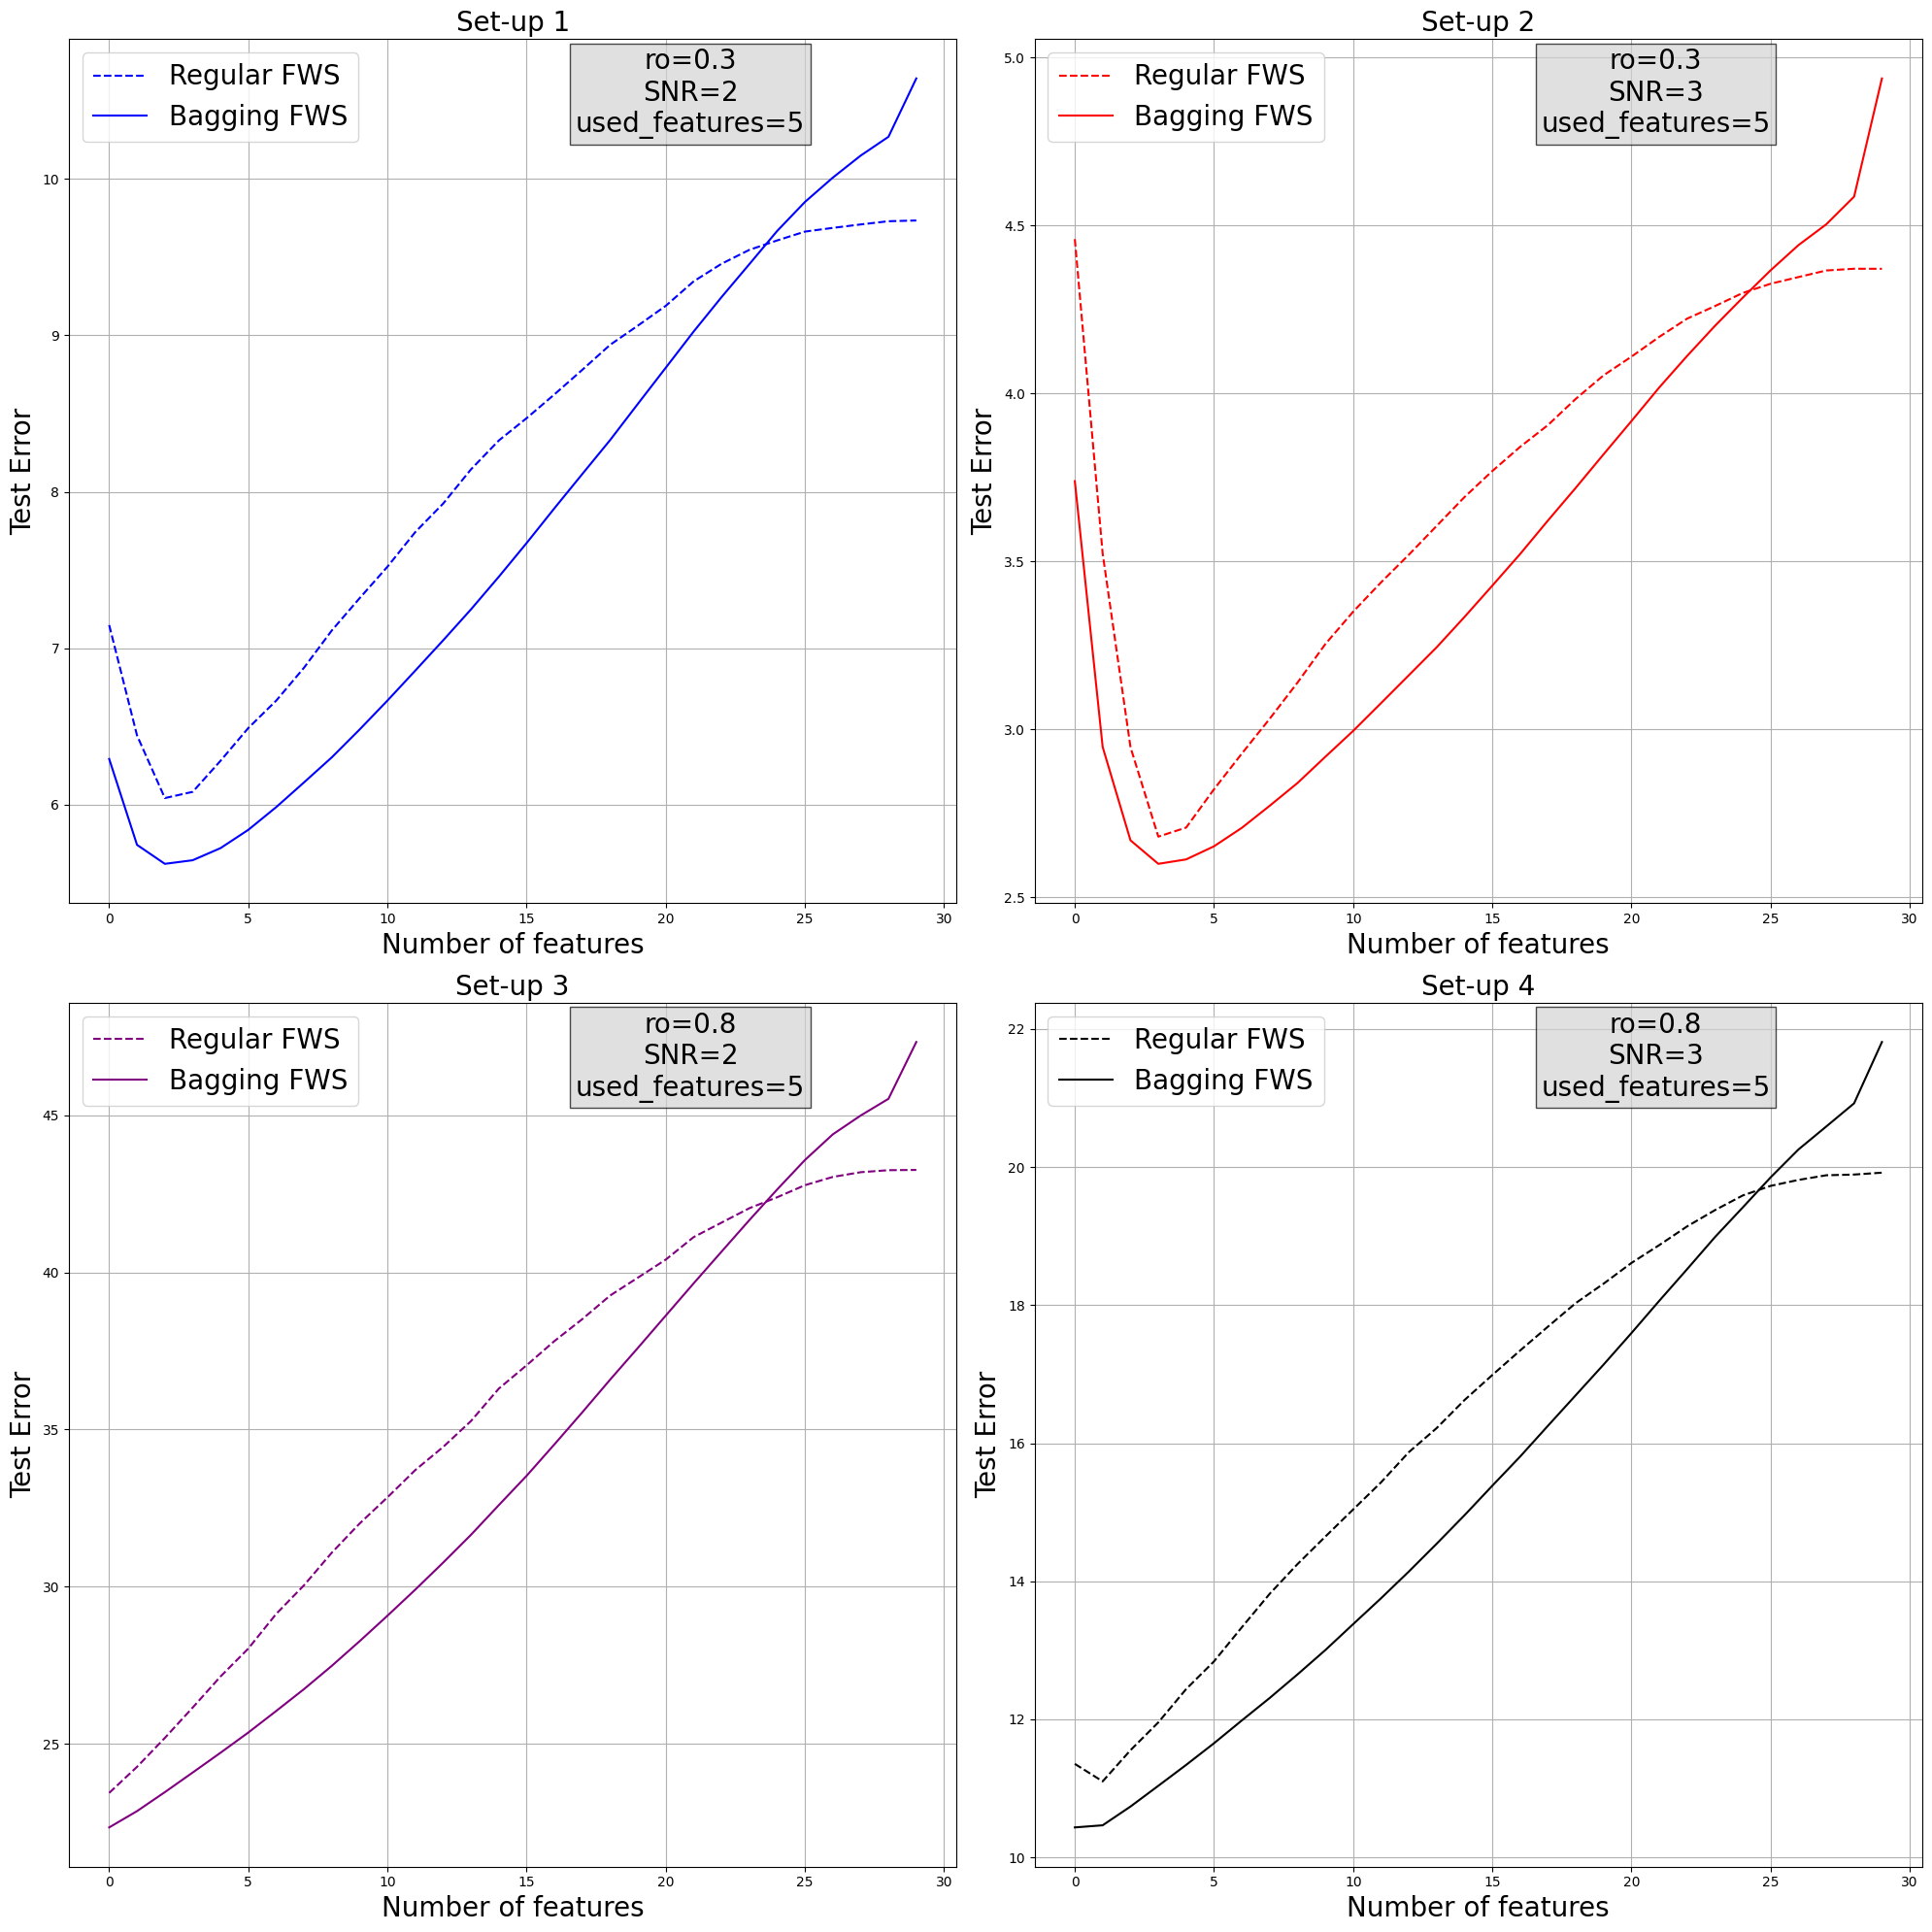

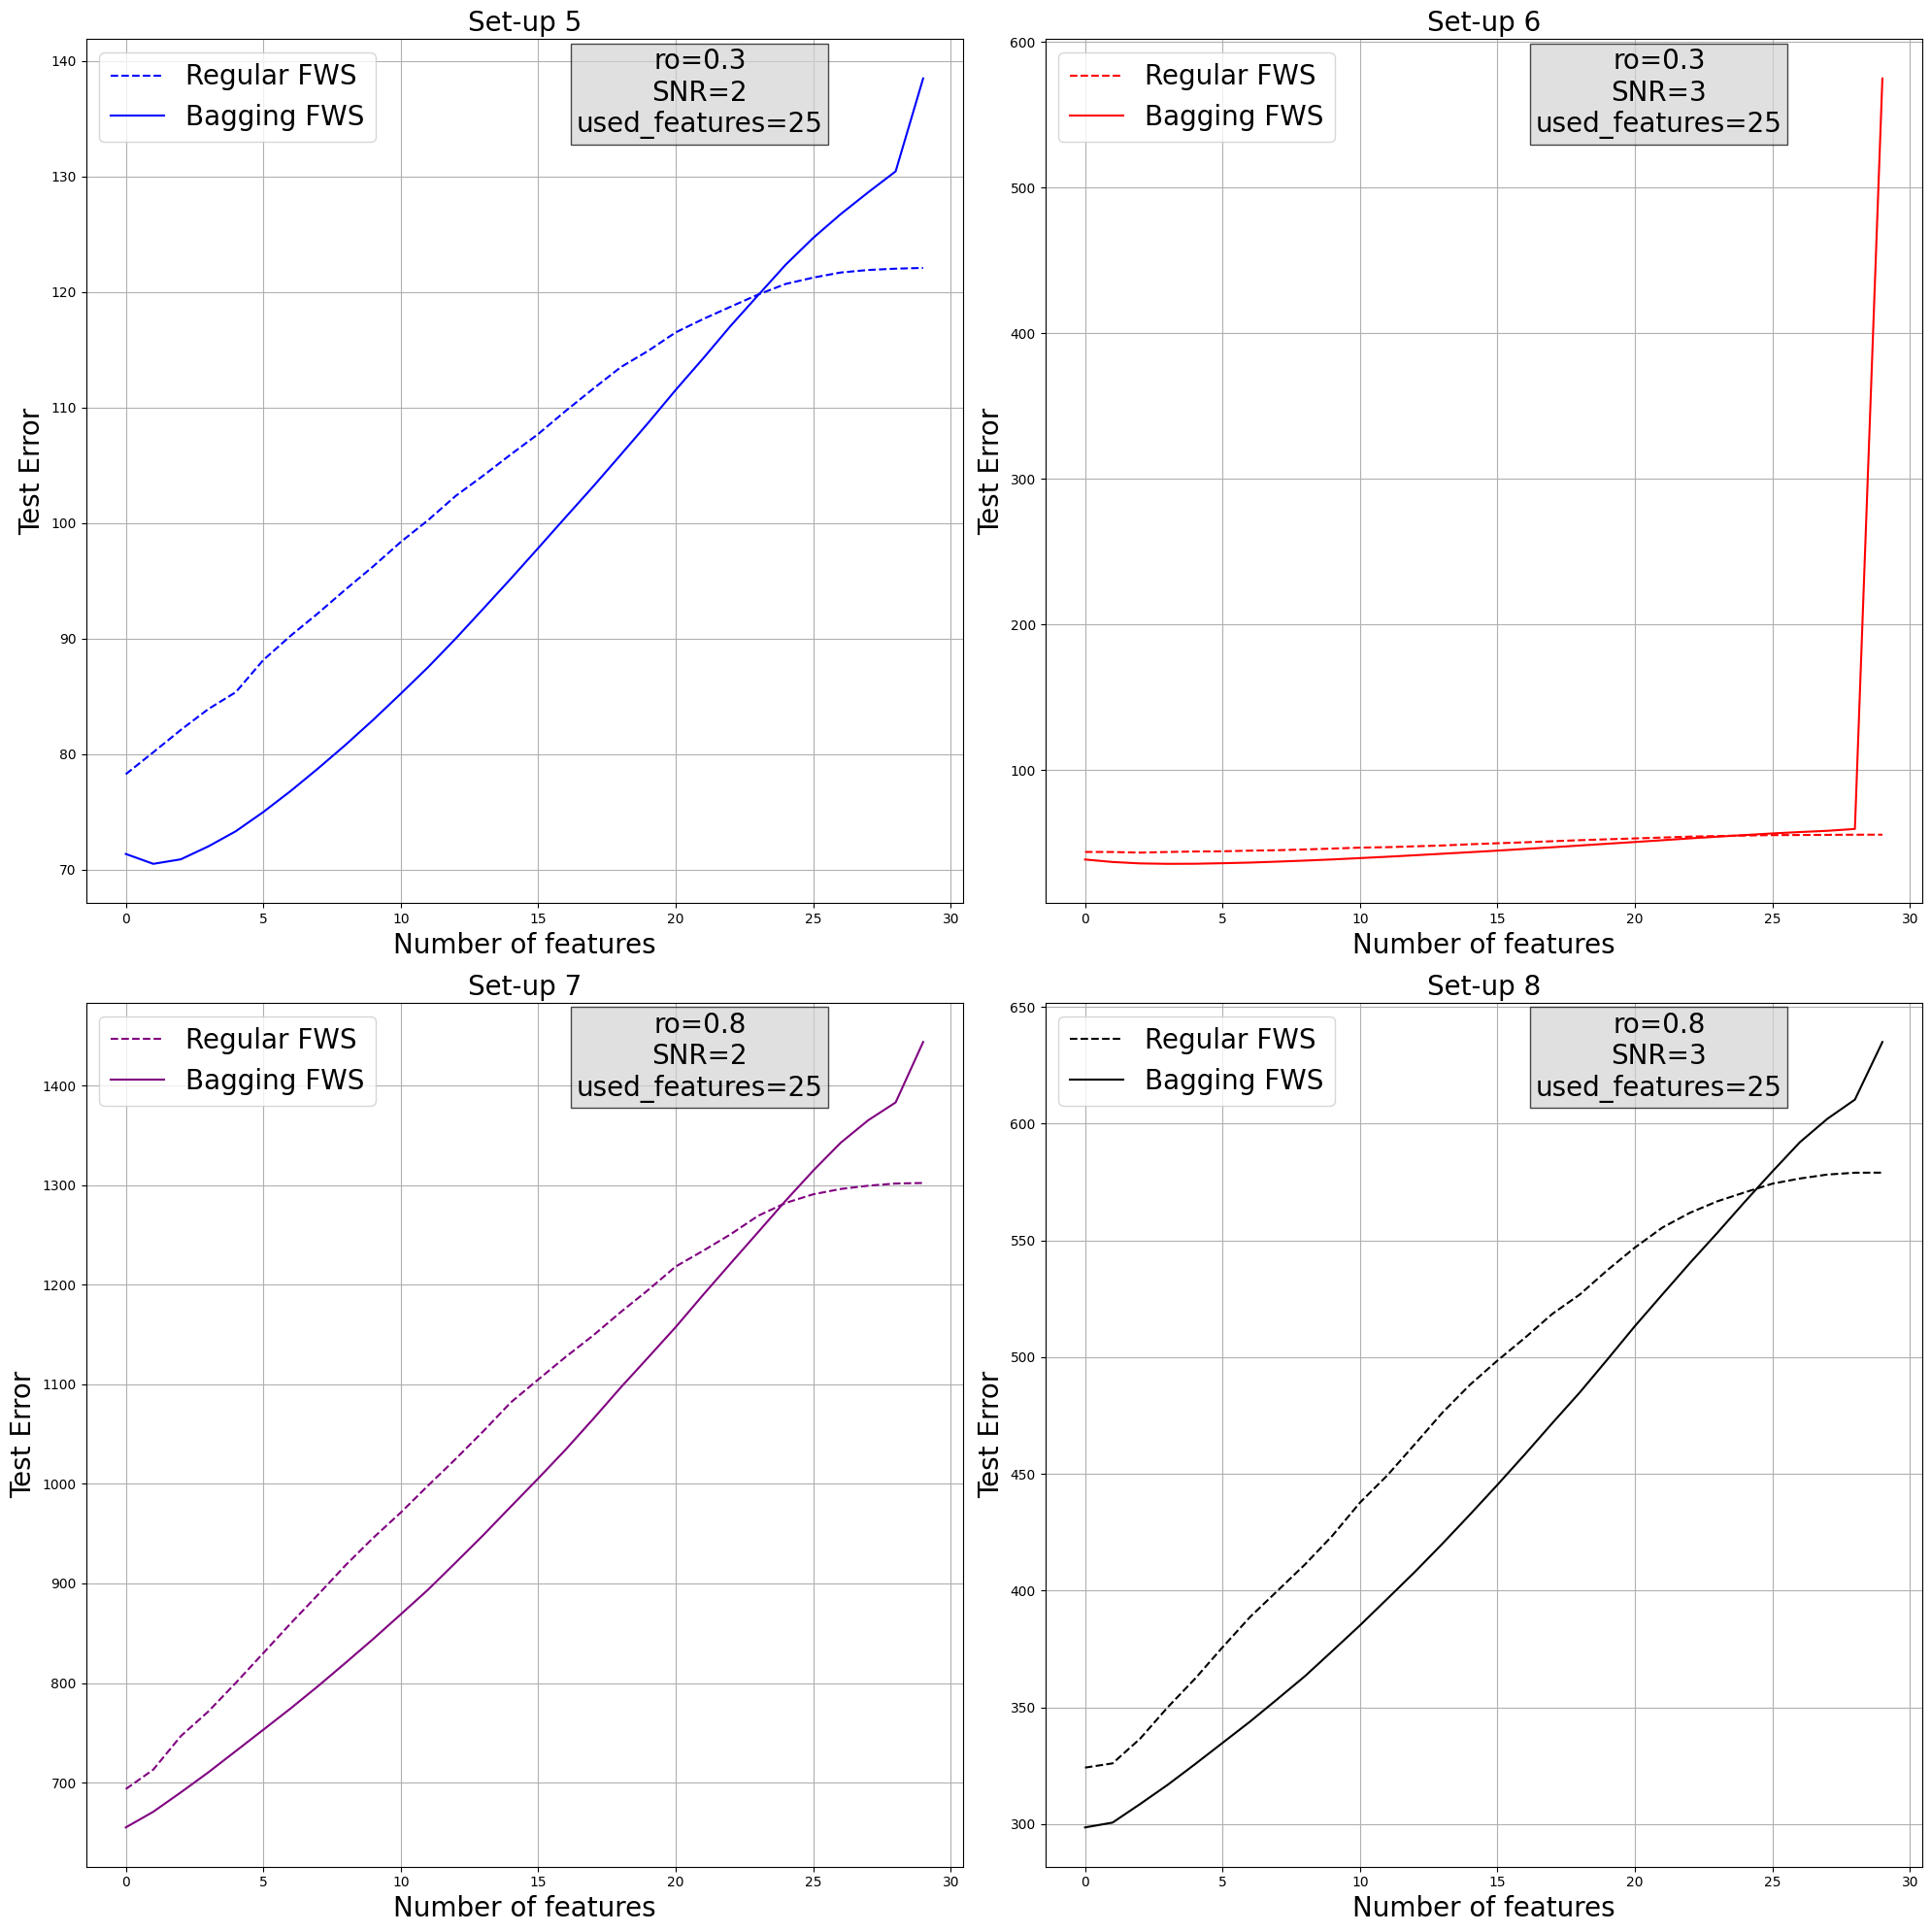

In [5]:
loaded_data = np.load('errors.npz') # to load the data 

errors_FWS_all = loaded_data['array1']
errors_bagging_all = loaded_data['array2']

L = [   ["ro=0.3","SNR=2","used_features=5"],
        ["ro=0.3","SNR=3","used_features=5"],
        ["ro=0.8","SNR=2","used_features=5"],
        ["ro=0.8","SNR=3","used_features=5"],
        ["ro=0.3","SNR=2","used_features=25"],
        ["ro=0.3","SNR=3","used_features=25"],
        ["ro=0.8","SNR=2","used_features=25"],
        ["ro=0.8","SNR=3","used_features=25"]] # just for the plots( ignore !)
COLORS = ['blue','red','purple','black','blue','red','purple','black']
num_subplots_per_figure = 4
NNN = [5, 25]
for group in range(2):
    fig, axs = plt.subplots(2, 2, figsize=(20, 20)) 
    axs = axs.flatten()
    start_index = group * num_subplots_per_figure
    for i in range(num_subplots_per_figure):
        idx = start_index + i
        ax = axs[i]
        ax.plot(errors_FWS_all[idx], label=f'Regular FWS', color=COLORS[idx], linestyle='--')
        ax.plot(errors_bagging_all[idx], label=f'Bagging FWS', color=COLORS[idx], linestyle='-')
        ax.set_xlabel('Number of features', fontsize=20)
        ax.set_ylabel('Test Error', fontsize=20)
        ax.legend(fontsize=20)
        info_text = "\n".join(L[idx])
        ax.text(0.7, 0.99, info_text, fontsize=20, bbox=dict(facecolor='lightgray', alpha=0.7), transform=ax.transAxes, ha='center', va='top')
        ax.set_title(f'Set-up {idx + 1}',fontsize=20)
        ax.grid(True)
    plt.tight_layout()
    plt.savefig(f'laytex/N_features={NNN[group]}_Bagging_FWS_vs_Regular_FWS.png')
    plt.show()
    plt.close(fig)